In [1]:
%load_ext autoreload



%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import time

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
GPU = "0"
os.environ["CUDA_VISIBLE_DEVICES"]=GPU

In [3]:
from frm_dataset_loader import load_dataset
from conf_dataset_1 import *


['ook', 'ask4', 'ask8', 'bpsk', 'qpsk', 'psk8', 'psk16', 'psk32', 'apsk16', 'apsk32', 'apsk64', 'qam16', 'qam32', 'qam64', 'gmsk', 'cpfsk']


In [4]:
fname = 'datasets/test_1.dat'

(comb_test,carrier_test,clean_test,fading_test,raw_test,
         freq_test,timing_offNum_test,timing_step_test,
         coeff_test,mod_test,snr_test) = load_dataset(fname,max_sps,len(mod_list))

In [5]:
from frm_nn_zoo_01 import create_dualPath

pkt_size_net = pkt_size
nn_all = create_dualPath(pkt_size = pkt_size_net,n_mods=len(mod_list))
# nn_all.summary()

/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/samer/miniconda3/en

/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom



(?, ?, ?, ?)
(?, 1024, 2)



In [6]:
nn_all.load_weights('models/001.h5')

In [7]:
predictions_all = nn_all.predict(comb_test)
pred_freq,pred_noisy,pred_fading,pred_clean,pred_timing_step,pred_timing_off,pred_mod  = predictions_all

In [8]:
mod_name_test = list(map( lambda x : mod_list[x],np.argmax(mod_test,-1)))

In [9]:
from frm_demod_utils import   demod_batch

In [10]:
slc_ber = slice(None,None)


In [11]:
t1 = time.time()
test_ser = demod_batch(pred_clean[slc_ber],raw_test[slc_ber],mod_name_test[slc_ber],max_sps,pred_timing_step[slc_ber],
                 np.maximum(pred_timing_off[slc_ber],0))
time.time()-t1

521.5827858448029

In [12]:
from frm_eval_utils import ecdf,calc_nmse

In [13]:
srt,prob = ecdf(test_ser[np.logical_not(np.isnan(test_ser))])

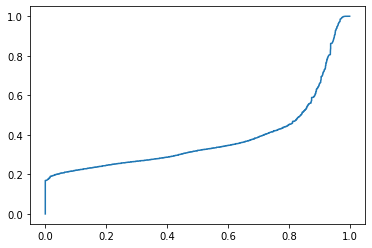

In [14]:
plt.plot(srt,prob)

In [15]:
nmse_all = calc_nmse(pred_fading,fading_test)
nmse2_all = calc_nmse(pred_clean,clean_test)
nmse2t_all = calc_nmse(pred_fading,clean_test)

In [16]:
print(np.mean(nmse_all),np.mean(nmse2_all),np.mean(nmse2t_all))

1.4347847576318815 1.4532892745123818 1.4586687735897244


In [17]:
pred_mod_dec = np.argmax(pred_mod,-1)

In [18]:
print(np.mean( np.argmax(mod_test,-1)==pred_mod_dec))

0.83784


In [19]:
import datetime

outputs = {}
outputs['dataset_params'] = [pkt_size,max_sps,mod_list,sps_rng,pulse_ebw_list,timing_offset_rng,fading_spread_rng,freq_err_rng,phase_err_rng,snr_rng]
outputs['date'] =  f'{datetime.datetime.now():%Y-%m-%d %H:%M:%S%z}'
outputs['dpn'] = (pred_freq,pred_timing_step,pred_timing_off,pred_mod_dec, nmse_all,nmse2_all,nmse2t_all,test_ser)

In [21]:
FNAME = '005'

In [22]:
import pickle
with open(f'outputs/{FNAME}.pkl','wb') as f:
    pickle.dump(outputs,f)